In [1]:
import numpy as np
import os
import cv2 as cv
from tqdm import tqdm
from scipy import ndimage
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from copy import deepcopy
import matplotlib.pyplot as plt
import ntpath
import pickle
import pdb
import timeit
import glob

ROOT = 'dataset/train/'
TEST_PATH = "C:/Users/Matei/Downloads/CAVA-2022-Tema2/validare/Validare"
characters = ["andy", "louie", "ora", "tommy", "unknown"]
l_window = 36
L_window = 36
dim_hog_cell = 6
num_positive_examples = -1
num_negative_examples = -1
save_model_path = 'dataset/models/'

In [2]:
def get_positive_descriptors():
    positive_descriptors = []
    count = 0
    for character in characters:
        path = ROOT + "positives/" + character + "/"
        image_paths = os.listdir(path)
        for img_path in tqdm(image_paths):
            image = cv.imread(path + img_path)
            image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
            image = cv.resize(image, (l_window, L_window))

            if count % 4 == 1:
                image = cv.flip(image, 1)
            if count % 4 == 2:
                image = ndimage.rotate(image, 5)
            if count % 4 == 3 :
                image = ndimage.rotate(image, -5)

            descr = hog(image, pixels_per_cell=(dim_hog_cell, dim_hog_cell), orientations=18,
                        cells_per_block=(2, 2), feature_vector=True)
            positive_descriptors.append(descr)
        count += 1


    return np.array(positive_descriptors[:num_positive_examples])

In [3]:
def get_negative_descriptors(save_path):
    path = ROOT + save_path
    negative_descriptors = []
    for img_path in tqdm(os.listdir(path)):
        image = cv.imread(path + img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        image = cv.resize(image, (l_window, L_window))

        descr = hog(image, pixels_per_cell=(dim_hog_cell, dim_hog_cell), orientations = 18,
                        cells_per_block=(2, 2), feature_vector=True)
        negative_descriptors.append(descr)

    return np.array(negative_descriptors[:num_negative_examples])

# Get descriptors

In [4]:
positive_descriptors = get_positive_descriptors()
negative_descriptors = get_negative_descriptors("negatives/normal/")
strong_desc = get_negative_descriptors("negatives/strong/")
negative_descriptors = np.concatenate((negative_descriptors, strong_desc))

 29%|██▉       | 2844/9698 [00:10<00:25, 267.81it/s]


KeyboardInterrupt: 

# Save descriptors

In [6]:
positive_descriptors.shape

(35478, 1800)

In [ ]:
np.save("dataset/descriptors/negatives.npy", negative_descriptors)
np.save("dataset/descriptors/positives.npy", positive_descriptors)

# Gather all data

In [5]:
positive_descriptors = np.load("dataset/descriptors/positives.npy")
negative_descriptors = np.load("dataset/descriptors/negatives.npy")

data = [(desc, 1) for desc in positive_descriptors[:num_positive_examples]] + [(desc, 0)
            for desc in negative_descriptors[:num_negative_examples]]
np.random.shuffle(data)

train_examples = []
train_labels = []

for entry in data:
    train_examples.append(entry[0])
    train_labels.append(entry[1])

train_examples = np.array(train_examples)
train_labels = np.array(train_labels)
train_examples.shape, train_labels.shape

((157178, 1800), (157178,))

In [6]:
validation = np.load("dataset/descriptors/validation.npy", allow_pickle=True)
val_examples = []
val_labels = []

for entry in validation:
        val_examples.append(entry[0])
        val_labels.append(entry[1])
val_examples = np.array(val_examples)
val_labels = np.array(val_labels)
val_examples.shape,val_labels.shape

((1416, 1800), (1416,))

# Train classifier

In [8]:
def train_classifier(train_examples, train_labels):
    #svm_file_name = save_model_path + '/final/svm'
    best_accuracy = 0
    best_c = 0
    best_model = None
    Cs = [1]

    for c in tqdm(Cs):
        print('Train classifier with c=%f' % c)
        model = LinearSVC(C=c)
        model.fit(train_examples, train_labels)
        acc = model.score(val_examples, val_labels)
        print(acc)
        if acc > best_accuracy:
            best_accuracy = acc
            best_c = c
            best_model = deepcopy(model)

    print('Performance of the classifier with c = %f' % best_c)
    #pickle.dump(best_model, open(svm_file_name, 'wb'))

    scores = best_model.decision_function(train_examples)
    positive_scores = scores[train_labels > 0]
    negative_scores = scores[train_labels <= 0]


    plt.plot(np.sort(positive_scores))
    plt.plot(np.zeros(len(positive_scores)))
    plt.plot(np.sort(negative_scores))
    plt.xlabel('Number of examples')
    plt.ylabel('Classifier score')
    plt.title('Distribution of the scores')
    plt.legend(['Positive examples scores', '0', 'Negative examples score'])
    plt.show()

    return best_model

  0%|          | 0/1 [00:00<?, ?it/s]

Train classifier with c=1.000000


100%|██████████| 1/1 [01:06<00:00, 66.36s/it]

0.972457627118644
Performance of the classifier with c = 1.000000


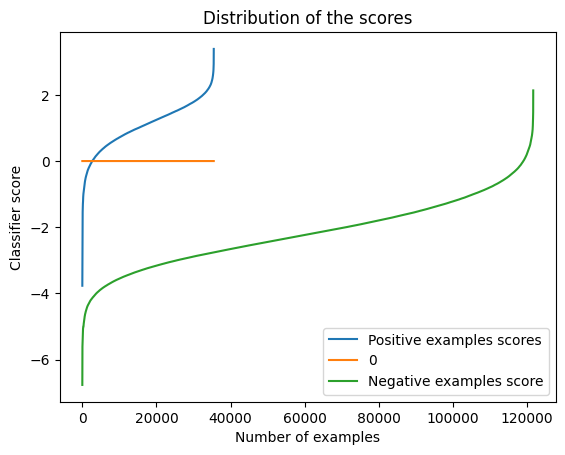

In [9]:
best_model = train_classifier(train_examples, train_labels)  # 97.4

In [9]:
labels = best_model.predict(val_examples)
ct_false_negative = 0
ct_false_positive = 0
for l1, l2 in zip(labels, val_labels):
    if l1 == 0 and l2 == 1:
        ct_false_negative += 1
    if l2 == 0 and l1 == 1:
        ct_false_positive += 1

print(f"false negative: {ct_false_negative}\nfalse positive: {ct_false_positive}")

NameError: name 'best_model' is not defined

In [ ]:
scores=best_model.decision_function(val_examples)
positive_scores = scores[val_labels > 0]
negative_scores = scores[val_labels <= 0]


plt.plot(np.sort(positive_scores))
plt.plot(np.zeros(len(positive_scores)))
plt.plot(np.sort(negative_scores))
plt.xlabel('Number of validation examples')
plt.ylabel('Classifier score')
plt.title('Distribution of scores')
plt.legend(['Positive examples score', '0', 'Negative examples score'])
plt.show()

In [ ]:
pickle.dump(best_model, open("dataset/models/best_choice", 'wb'))

 # Task 2

In [11]:
def get_character_descriptors(character):
    positive_descriptors = []
    path = ROOT + "positives/" + character + "/"
    image_paths = os.listdir(path)

    for img_path in tqdm(image_paths):
        image = cv.imread(path + img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        init_image = cv.resize(image, (l_window, L_window))

        descr = hog(init_image, pixels_per_cell=(dim_hog_cell, dim_hog_cell), orientations=18,
                        cells_per_block=(2, 2), feature_vector=True)
        positive_descriptors.append(descr)

        image = cv.flip(init_image, 1)
        descr = hog(image, pixels_per_cell=(dim_hog_cell, dim_hog_cell), orientations=18,
                        cells_per_block=(2, 2), feature_vector=True)
        positive_descriptors.append(descr)

    negative_descriptors = []
    for c in characters:
        if c != character:
            print(c)
            path = ROOT + "positives/" + c + "/"
            image_paths = os.listdir(path)

            for img_path in tqdm(image_paths):
                image = cv.imread(path + img_path)
                image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
                image = cv.resize(image, (l_window, L_window))

                descr = hog(image, pixels_per_cell=(dim_hog_cell, dim_hog_cell), orientations=18,
                        cells_per_block=(2, 2), feature_vector=True)
                negative_descriptors.append(descr)

    neg = np.load("dataset/descriptors/negatives.npy")
    negative_descriptors.extend(neg)

    data = [(desc, 1) for desc in positive_descriptors] + [(desc, 0)
            for desc in negative_descriptors]
    np.random.shuffle(data)

    train_examples = []
    train_labels = []

    for entry in data:
        train_examples.append(entry[0])
        train_labels.append(entry[1])

    train_examples = np.array(train_examples)
    train_labels = np.array(train_labels)
    return train_examples, train_labels

# Andy

In [12]:
train_examples, train_labels = get_character_descriptors("andy")
train_examples.shape, train_labels.shape

100%|██████████| 9698/9698 [00:44<00:00, 216.92it/s]


louie


100%|██████████| 10711/10711 [00:50<00:00, 214.07it/s]


ora


100%|██████████| 7946/7946 [00:34<00:00, 231.52it/s]


tommy


100%|██████████| 6048/6048 [00:25<00:00, 236.26it/s]


unknown


100%|██████████| 6533/6533 [00:27<00:00, 236.30it/s]


((172336, 1800), (172336,))

  0%|          | 0/1 [00:00<?, ?it/s]

Train classifier with c=1.000000


100%|██████████| 1/1 [00:49<00:00, 49.76s/it]

0.7733050847457628
Performance of the classifier with c = 1.000000


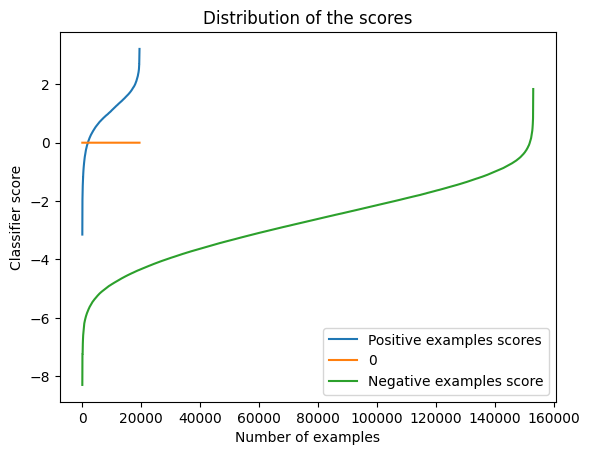

In [13]:
best_model = train_classifier(train_examples, train_labels)
pickle.dump(best_model, open("dataset/models/final/andy2", 'wb'))

# Louie

In [14]:
train_examples, train_labels = get_character_descriptors("louie")
train_examples.shape, train_labels.shape

100%|██████████| 10711/10711 [00:52<00:00, 205.69it/s]


andy


100%|██████████| 9698/9698 [00:30<00:00, 313.11it/s]


ora


100%|██████████| 7946/7946 [00:19<00:00, 399.99it/s]


tommy


100%|██████████| 6048/6048 [00:15<00:00, 396.41it/s]


unknown


100%|██████████| 6533/6533 [00:08<00:00, 774.25it/s]


((173349, 1800), (173349,))

  0%|          | 0/1 [00:00<?, ?it/s]

Train classifier with c=1.000000


100%|██████████| 1/1 [00:58<00:00, 58.08s/it]

0.780367231638418
Performance of the classifier with c = 1.000000


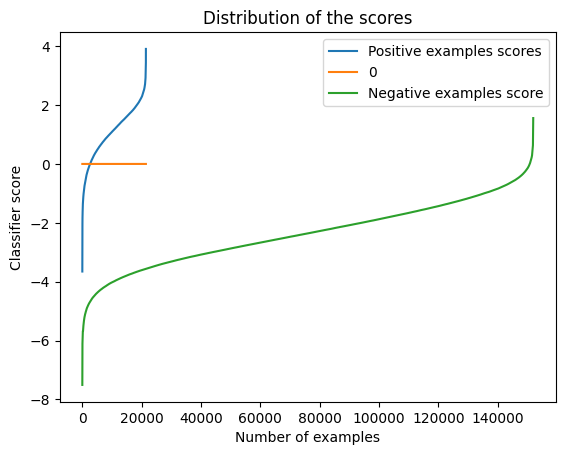

In [15]:
best_model = train_classifier(train_examples, train_labels)
pickle.dump(best_model, open("dataset/models/final/louie2", 'wb'))

# Ora

In [19]:
train_examples, train_labels = get_character_descriptors("ora")
train_examples.shape, train_labels.shape

100%|██████████| 7946/7946 [00:18<00:00, 422.56it/s]


andy


100%|██████████| 9698/9698 [00:31<00:00, 311.32it/s]


louie


100%|██████████| 10711/10711 [00:43<00:00, 248.47it/s]


tommy


100%|██████████| 6048/6048 [00:29<00:00, 202.78it/s]


unknown


100%|██████████| 6533/6533 [00:10<00:00, 646.74it/s]


((170584, 1800), (170584,))

  0%|          | 0/1 [00:00<?, ?it/s]

Train classifier with c=1.000000


100%|██████████| 1/1 [00:50<00:00, 50.03s/it]

0.7641242937853108
Performance of the classifier with c = 1.000000


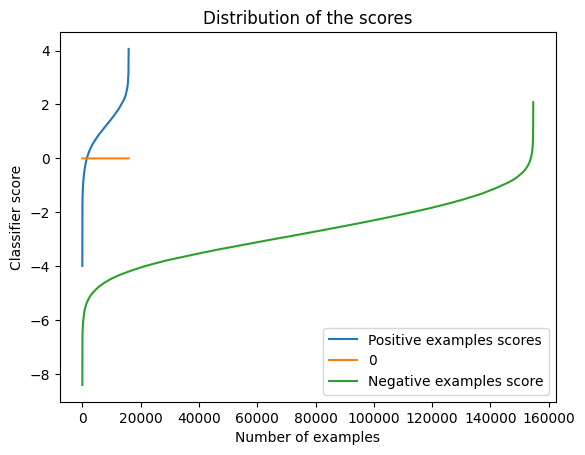

In [20]:
best_model = train_classifier(train_examples, train_labels)
pickle.dump(best_model, open("dataset/models/final/ora2", 'wb'))

# Tommy

In [17]:
train_examples, train_labels = get_character_descriptors("tommy")
train_examples.shape, train_labels.shape

100%|██████████| 6048/6048 [00:19<00:00, 313.95it/s]


andy


100%|██████████| 9698/9698 [00:31<00:00, 312.55it/s]


louie


100%|██████████| 10711/10711 [00:43<00:00, 243.88it/s]


ora


100%|██████████| 7946/7946 [00:20<00:00, 381.08it/s]


unknown


100%|██████████| 6533/6533 [00:09<00:00, 680.50it/s]


((168686, 1800), (168686,))

  0%|          | 0/1 [00:00<?, ?it/s]

Train classifier with c=1.000000


100%|██████████| 1/1 [01:03<00:00, 63.07s/it]

0.7436440677966102
Performance of the classifier with c = 1.000000


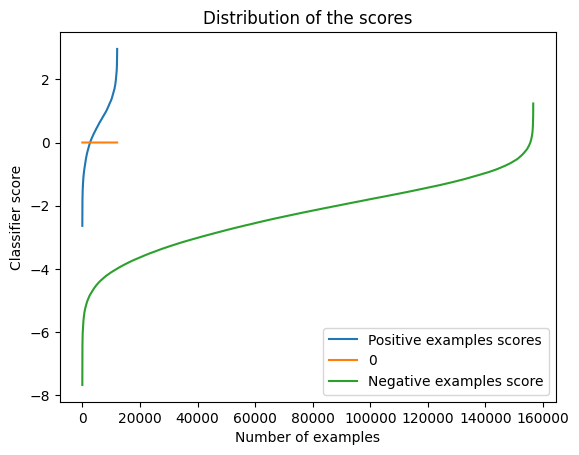

In [18]:
best_model = train_classifier(train_examples, train_labels)
pickle.dump(best_model, open("dataset/models/final/tommy2", 'wb'))